In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

gifPath = Path("/Users/sasa/Workspace/Python/notes/file_ope/convolution.gif")

with open(gifPath,'rb') as f:
  display.Image(data=f.read(), format='png')

img size: (256, 256, 3)


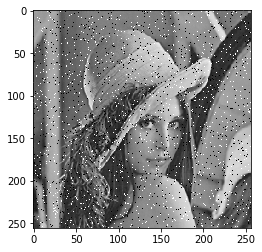

In [2]:
# OpenCVを使った方法(filter2d)

import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/Users/sasa/Workspace/Python/notes/file_ope/Lenna_gray_noise.png", 1)
print(f"img size: {img.shape}")
plt.imshow(img)

In [3]:
kernel = np.full((3, 3), 1/9)
print(kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


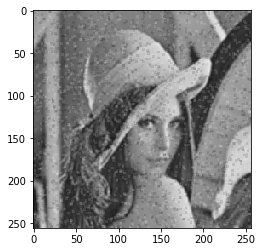

In [4]:
img2 = cv2.filter2D(img, -1, kernel)
plt.imshow(img2)

numpyで畳み込み演算(numpy.convolve)

https://deepage.net/features/numpy-convolve.html

In [5]:
ary = np.array([0, 1, 2, 3, 4, 5])
kernel = np.array([0.2, 0.8])
# kernelは各軸に対して反転された物がconvolutionされる

print(f"same mode: {np.convolve(ary, kernel, mode='same')}")
print(f"full mode: {np.convolve(ary, kernel, mode='full')}")
print(f"valid mode: {np.convolve(ary, kernel, mode='valid')}")

same mode: [0.  0.2 1.2 2.2 3.2 4.2]
full mode: [0.  0.2 1.2 2.2 3.2 4.2 4. ]
valid mode: [0.2 1.2 2.2 3.2 4.2]


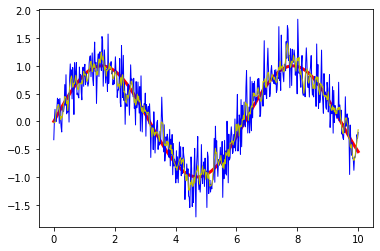

In [6]:
# 移動平均を使ってノイズの混じったデータを平滑化
x = np.linspace(0, 10, 500)
y1 = np.sin(x)
y2 = y1 + np.random.randn(500)*0.3 # randn: 正規分布

kernel = np.ones(5)/5.0
y3 = np.convolve(y2, kernel, mode='same')

plt.plot(x, y1, 'r', linewidth=3)
plt.plot(x, y2, 'b', linewidth=1)
plt.plot(x, y3, 'y', linewidth=1)
plt.show()

画像処理  これはConvolutionとは違うかも・・・

https://qiita.com/uosansatox/items/4fa34e1d8d95d8783536

In [7]:
from PIL import Image
import numpy as np

img = Image.open('/Users/sasa/Workspace/Python/notes/file_ope/yuri.jpg')
width, height = img.size
print(f"image size: {img.size}")

image size: (1600, 1066)


In [8]:
# オリジナル画像と同じサイズのImageオブジェクトを作成
img2 = Image.new('RGB', (width, height))

In [9]:
# 画像ファイルを配列化
img_pixels = []

for y in range(height):
    for x in range(width):
        # getpixel((x, y))で左からx番目、上からy番目のピクセルの色を取得し、img_pixelsに追加する
        img_pixels.append(img.getpixel((x, y)))
img_pixels = np.array(img_pixels).reshape(height, width, 3)
print(f"size: {img_pixels.shape}")

size: (1066, 1600, 3)


In [10]:
# 画素の取得
img_pixels[0][100]

array([  0,  87, 193])

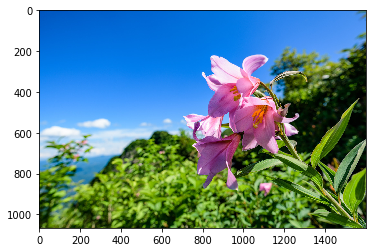

In [11]:
plt.imshow(img_pixels)

In [12]:
%reset
# ぼかし加工をしてみる
from PIL import Image
import numpy as np

img = Image.open('/Users/sasa/Workspace/Python/notes/file_ope/yuri.jpg')
width, height = img.size
filter_size = 20
img_blur = Image.new('RGB', (width - filter_size, height - filter_size))
img_pixels = np.array([[img.getpixel((x, y)) for x in range(width)] for y in range(height)])

In [13]:
print(f"size: {img_pixels.shape}")

size: (1066, 1600, 3)


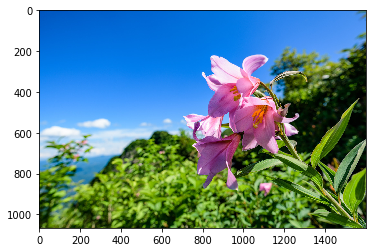

In [14]:
import matplotlib.pyplot as plt
plt.imshow(img_pixels)

img_blur.shape: (1046, 1580, 3)


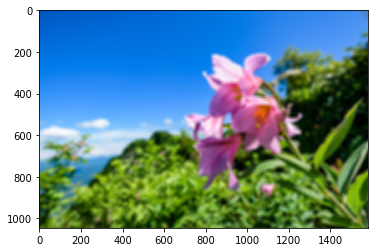

In [15]:
for y in range(height - filter_size):
    for x in range(width - filter_size):
        # 位置(x, y)を起点に縦横フィルターサイズの小さい画像をオリジナル画像から切り取る
        partial_img = img_pixels[y:y + filter_size, x:x + filter_size]
        # 小さい画像の各ピクセルの値を一列に並べる
        color_array = partial_img.reshape(filter_size ** 2, 3)
        # 各R, G, Bそれぞれの平均を求めて加工画像の位置(x, y)のピクセルにセットする
        mean_r, mean_g, mean_b = color_array.mean(axis = 0) # axis=0:列ごと
        img_blur.putpixel((x, y), (int(mean_r), int(mean_g), int(mean_b)))

# PILのImageオブジェクトをいったんndarrayに変換
img_ary = np.array(img_blur)
print(f"img_blur.shape: {img_ary.shape}")
# フィルターサイズ分だけ画像サイズが小さくなってしまっている
plt.imshow(img_ary)

img_mosaic.shape: (1066, 1600, 3)


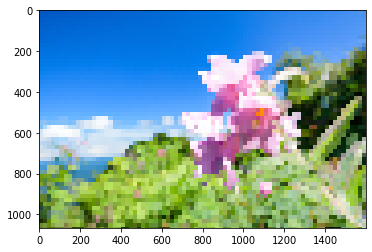

In [16]:
# モザイク フィルターサイズ分の部分画像内で一番濃い色で部分画像と同じ大きさの画像を生成

filter_size = 20
img_mosaic = Image.new('RGB', (width, height))

def draw_partial_img(img_mosaic, start_x, start_y, partial_size_x, partial_size_y, pixel_color):
    for y in range(start_y, start_y + partial_size_y):
        for x in range(start_x, start_x + partial_size_x):
            img_mosaic.putpixel((x, y), pixel_color)

for y in range(0, height, filter_size):
    for x in range(0, width, filter_size):
        partial_img = img_pixels[y:y + filter_size, x:x + filter_size]
        # 色の配列になるように変換
        color_array = partial_img.reshape(partial_img.shape[0] * partial_img.shape[1], 3) # filter_size ** 2と同じ(?)
        # 各ピクセルごとのr + g + bが最大値をとる物の番号を取得する
        # →切り出した画像の中で一番濃い色をの番号
        max_index = np.argmax(color_array.sum(axis=1)) # axis=1:行ごと
        max_r , max_g, max_b = color_array[max_index]
        # (x, y)を起点に縦横フィルターサイズで単色の画像をセット
        draw_partial_img(img_mosaic, x, y, partial_img.shape[1], partial_img.shape[0], (max_r, max_g, max_b))

img_ary = np.array(img_mosaic)
print(f"img_mosaic.shape: {img_ary.shape}")
plt.imshow(img_ary)

img_mosaic.shape: (1066, 1600, 3)


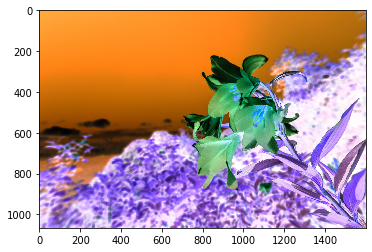

In [17]:
# 色の反転

img_reverse = Image.new('RGB', (width, height))

reverse_color_pixels = 255 - img_pixels
for y in range(height):
    for x in range(width):
        r, g, b = reverse_color_pixels[y][x]
        img_reverse.putpixel((x, y), (r, g, b))

img_ary = np.array(img_reverse)
print(f"img_mosaic.shape: {img_ary.shape}")
plt.imshow(img_ary)

# Convolutionをフルスクラッチでやってみる

https://karaage.hatenadiary.jp/entry/2017/07/31/073000

In [18]:
%reset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## 入力をそのまま出力するフィルタ

||||
|:-:|:-:|:-:|
|0|0|0|
|0|1|0|
|0|0|0|


img.shape: (520, 520, 3)


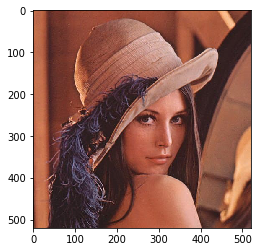

In [19]:
# img = Image.open('/Users/sasa/Workspace/Python/notes/file_ope/mesh.jpg')
img = Image.open('/Users/sasa/Workspace/Python/notes/file_ope/lena.jpg')
img_ary = np.array(img)
print(f"img.shape: {img_ary.shape}")
plt.imshow(img_ary)

img_conv.shape: (520, 520, 3)


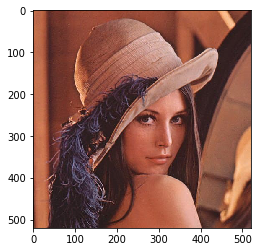

In [20]:
# 何も変えないフィルタ
filter = [0, 0, 0,
          0, 1, 0,
          0, 0, 0]

width, height = img.size
img_conv = Image.new('RGB', (width, height))

# ここで[[for y]for x]の順にしないと90度回転しちゃう
img_pixels = np.array([[img.getpixel((x, y)) for y in range(height)] for x in range(width)])
# plt.imshow(img_pixels.reshape(height, width, 3))
color = np.zeros((len(filter), 3))

for y in range(1, height - 1):
    for x in range(1, width - 1):
        # [[for y]for x]の順になってるから合わせる
        color[0] = img_pixels[x-1, y-1]
        color[1] = img_pixels[x-1, y]
        color[2] = img_pixels[x-1, y+1]
        color[3] = img_pixels[x  , y-1]
        color[4] = img_pixels[x  , y]
        color[5] = img_pixels[x  , y+1]
        color[6] = img_pixels[x+1, y-1]
        color[7] = img_pixels[x+1, y]
        color[8] = img_pixels[x+1, y+1]

        sum_color = np.zeros(3)
        for i in range(len(filter)):
            sum_color += color[i] * filter[-(i + 1)] #　フィルター(kernel)は反転させる
        
        r, g, b = map(int, sum_color)

        img_conv.putpixel((x, y), (r, g, b))

img_ary = np.array(img_conv)
print(f"img_conv.shape: {img_ary.shape}")
plt.imshow(img_ary)

In [21]:
def convolution(img, kernel):
    width, height = img.size
    img_conv = Image.new('RGB', (width, height))

    # ここで[[for y]for x]の順にしないと90度回転しちゃう
    img_pixels = np.array([[img.getpixel((x, y)) for y in range(height)] for x in range(width)])
    # plt.imshow(img_pixels.reshape(height, width, 3))
    color = np.zeros((len(kernel), 3))

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            # [[for y]for x]の順になってるから合わせる
            color[0] = img_pixels[x-1, y-1]
            color[1] = img_pixels[x-1, y]
            color[2] = img_pixels[x-1, y+1]
            color[3] = img_pixels[x  , y-1]
            color[4] = img_pixels[x  , y]
            color[5] = img_pixels[x  , y+1]
            color[6] = img_pixels[x+1, y-1]
            color[7] = img_pixels[x+1, y]
            color[8] = img_pixels[x+1, y+1]

            sum_color = np.zeros(3)
            for i in range(len(kernel)):
                sum_color += color[i] * kernel[-(i + 1)]
            
            r, g, b = map(int, sum_color)

            img_conv.putpixel((x, y), (r, g, b))

    img_ary = np.array(img_conv)
    return img_ary

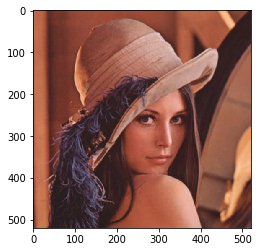

In [22]:
kernel2 = np.full(9, 1/9.0)
blur_img_ary = convolution(img, kernel2)
plt.imshow(blur_img_ary)

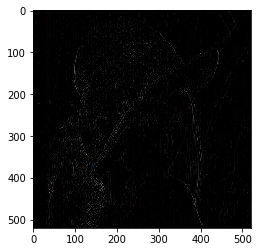

In [23]:
# edgeフィルタ
kernel3 = [0, 1,  0,
           0, -2, 0,
           0, 1,  0]
edge_img_ary = convolution(img, kernel3)
plt.imshow(edge_img_ary)

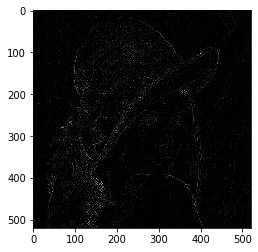

In [24]:
kernel4 = [0, 1,  0,
           1, -4, 1,
           0, 1,  0]
edge_img_ary = convolution(img, kernel4)
plt.imshow(edge_img_ary)

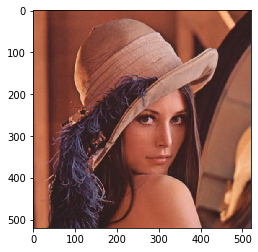

In [25]:
# ガウシアンフィルタ
kernel4 = np.array([1, 2, 1,
                    2, 4, 2,
                    1, 2, 1])/16
edge_img_ary = convolution(img, kernel4)
plt.imshow(edge_img_ary)

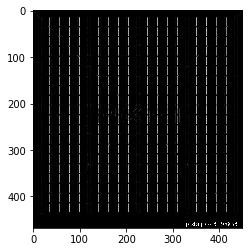

In [26]:
# 格子画像からわかりやすく縦のエッジ抽出
img = Image.open('/Users/sasa/Workspace/Python/notes/file_ope/mesh.jpg')
edge_img_ary = convolution(img, kernel3)
plt.imshow(edge_img_ary)

In [27]:
# 関数を一般化(様々なサイズのフィルターに対応)させる
def convolution2(img, kernel):
    width, height = img.size
    img_conv = Image.new('RGB', (width, height))

    # ここで[[for y]for x]の順にしないと90度回転しちゃう
    # img_pixels: [R, G, B]*画素数分の配列
    img_pixels = np.array([[img.getpixel((x, y)) for y in range(height)] for x in range(width)])
    # plt.imshow(img_pixels.reshape(height, width, 3))
    color = np.zeros((len(kernel), 3))
    filter_shape = int(np.sqrt(len(kernel))/2)

    for y in range(filter_shape, height - filter_shape):
        for x in range(filter_shape, width - filter_shape):
            # [[for y]for x]の順になってるから合わせる. color[0]には[R, G, B]の画素情報
            color = img_pixels[x-filter_shape:x+filter_shape+1, y-filter_shape:y+filter_shape+1].reshape(-1, 3)

            sum_color = np.zeros(3)
            for i in range(len(kernel)):
                sum_color += color[i] * kernel[-(i + 1)]
            
            r, g, b = map(int, sum_color)

            img_conv.putpixel((x, y), (r, g, b))

    img_ary = np.array(img_conv)
    return img_ary

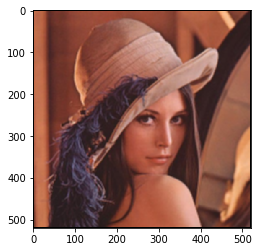

In [28]:
img = Image.open('/Users/sasa/Workspace/Python/notes/file_ope/lena.jpg')
kernel5 = np.full(25, 1/25.0)
blur_img_ary = convolution2(img, kernel5)
plt.imshow(blur_img_ary)
# ボケ感が強くなっている

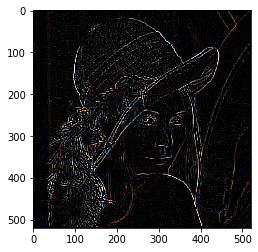

In [29]:
kernel6 = [1, 0, 0, 0, 1,
           0, 0, 0, 0, 0,
           0, 0, -4, 0, 0,
           0, 0, 0, 0, 0,
           1, 0, 0, 0, 1]
edge_img_ary = convolution2(img, kernel6)
plt.imshow(edge_img_ary)

今の畳み込みの指定だと、カーネルサイズによって生成される画像のサイズが小さくなってしまう→

~~畳み込みの前に、画像配列の外側を0で囲むなどの処理が必要(?)~~

特に必要ないぽい

https://products.sint.co.jp/aisia/blog/vol1-16